In [1]:
import json
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import joblib
import matplotlib.cm as cm
from scipy import stats
import matplotlib

## load data

In [2]:
df = pd.read_pickle('recipes_release.pkl')

## summary stats

In [3]:
alltags = df.rezept_tags.values
flatten = lambda l: [item for sublist in l for item in sublist]
alltags = flatten(alltags)
print("number of different tags in dataset: ", len(np.unique(alltags)))
from collections import Counter
import operator
import pprint as pprint
counts = Counter(alltags)
counts = sorted(counts.items(), key=operator.itemgetter(1),reverse=True)
pprint.pprint(counts[:20])

number of different tags in dataset:  168
[('Hauptspeise', 95943),
 ('Gemüse', 81718),
 ('Backen', 69421),
 ('einfach', 64924),
 ('Schnell', 62335),
 ('Vegetarisch', 53756),
 ('gekocht', 44402),
 ('Kuchen', 31013),
 ('Europa', 30113),
 ('Braten', 27985),
 ('Sommer', 27971),
 ('Party', 27822),
 ('Schwein', 27313),
 ('Snack', 23225),
 ('Herbst', 22914),
 ('raffiniert oder preiswert', 21832),
 ('Vorspeise', 21691),
 ('Dessert', 19513),
 ('Nudeln', 19436),
 ('Frucht', 18848)]


In [4]:
print('num recipes:', len(df))
print('num ratings:', sum(df.num_votes))
print('date range:', df.rezept_datum.min(),' to ', df.rezept_datum.max())

num recipes: 243333
num ratings: 2550651
date range: 2000-10-18 10:00:00  to  2018-03-08 16:42:12


# macro level analysis

In [5]:
# let's use top 50
tags = []
for k in range(50):
    t = counts[k][0]
    df[t] = [t in tags for tags in df.rezept_tags.values]
    tags.append(t)

In [6]:
df['ones'] = np.zeros(shape=len(df))+1.
dX = df[tags + ['rezept_datum']+['ones']]
dX = dX.set_index(pd.DatetimeIndex(df['rezept_datum']))

# aggreagte monthly
dX = dX.resample('1M').sum()
dX = dX.cumsum()

dX = dX.apply(lambda x: (1.0*x)/(x['ones']), axis=1)
dX = dX[dX.index>pd.to_datetime('2002')]
dX12 = dX
dX12_share = dX12.copy()

In [7]:
df['ones'] = np.zeros(shape=len(df))+1.
dX = df[tags + ['rezept_datum']+['ones']]
dX = dX.set_index(pd.DatetimeIndex(df['rezept_datum']))
dX = dX.resample('1M').sum()
dX = dX.apply(lambda x: x/(x['ones']+1.), axis=1)
dX12 = dX.rolling(12).mean()

## let's see the patterns on monthly scale and smoothed

/Users/yuki/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


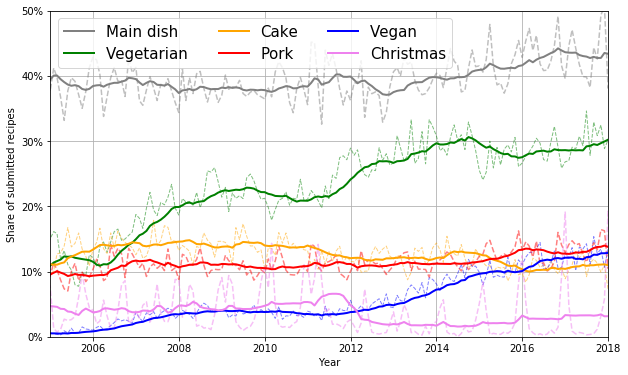

In [8]:
fig = plt.figure(figsize=(10,6))
ax= fig.add_subplot(111)

import matplotlib
matplotlib.rcParams.update({'font.size': 15})

alpha=0.5
ax.plot(dX.index,dX['Vegetarisch'].values,
         color='g',linewidth=1 ,ls='--',alpha=alpha)
ax.plot(dX.index,dX['Kuchen'].values,
        color='orange',linewidth=1,ls='--',alpha=alpha)
ax.plot(dX.index,dX['Vegan'].values,
         color='b',linewidth=1,ls='--',alpha=alpha)
ax.plot(dX.index,dX['Schwein'].values ,color='r',ls='--' ,alpha=alpha)
ax.plot(dX.index,dX['Hauptspeise'].values ,color='grey',ls='--' ,alpha=alpha)

ax.plot(dX.index,dX['Weihnachten'].values,
         color='violet',ls='--',alpha=alpha)


ax.plot(dX.index,1*dX12['Hauptspeise'].values , 
         label='Main dish',color='grey',linewidth=2 )
ax.plot(dX.index,dX12['Vegetarisch'],
         label='Vegetarian',color='g',linewidth=2 )
ax.plot(dX.index,dX12['Kuchen'],
         label='Cake',color='orange',linewidth=2)
ax.plot(dX.index,1*dX12['Schwein'].values,
         label='Pork',color='r',linewidth=2 )
ax.plot(dX.index,dX12['Vegan'],
         label='Vegan',color='b',linewidth=2)
ax.plot(dX.index,dX12['Weihnachten'],
         label='Christmas',color='violet',linewidth=2 )


ax.set_xlim((pd.to_datetime('01-01-2005'),pd.to_datetime('01-01-2018')))
ax.set_ylim((0.0,.5))
ax.set_xlabel(r'Year')
ax.set_ylabel(r'Share of submitted recipes')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.legend(ncol=3)
plt.grid('on')

## let's compare platform share vs submission share

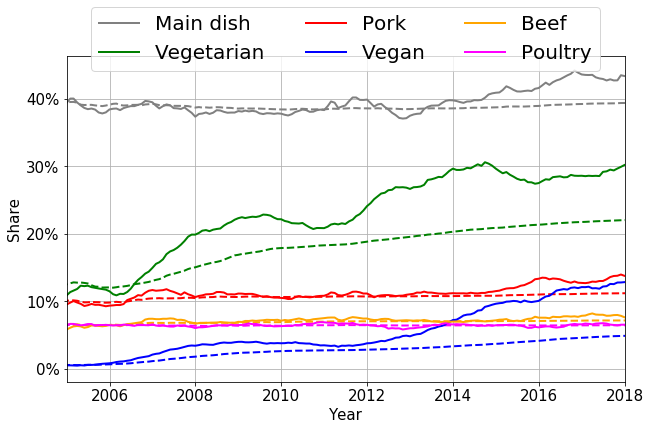

In [9]:
fig = plt.figure(figsize=(10,6))
ax= fig.add_subplot(111)

import matplotlib
matplotlib.rcParams.update({'font.size': 20})

alpha=0.5

ax.plot(dX12_share.index,1*dX12_share['Hauptspeise'].values, #dX12['Weihnachten'],
         label='',color='grey',linewidth=2 ,ls='--')
ax.plot(dX12_share.index,dX12_share['Vegetarisch'],label='',
         color='g',linewidth=2 ,ls='--')
ax.plot(dX12_share.index,dX12_share['Rind'],label='',
         color='orange',linewidth=2,ls='--')
ax.plot(dX12_share.index,dX12_share['Vegan'],label='',
         color='b',linewidth=2,ls='--')
ax.plot(dX12_share.index,dX12_share['Schwein'],label='',
         color='r',linewidth=2,ls='--')
ax.plot(dX12_share.index,dX12_share['Geflügel'],label='',
         color='magenta',linewidth=2,ls='--')

ax.plot(dX.index,1*dX12['Hauptspeise'].values , #dX12['Weihnachten'],
         label='Main dish',color='grey',linewidth=2 )
ax.plot(dX.index,dX12['Vegetarisch'],
         label='Vegetarian',color='g',linewidth=2)
ax.plot(dX.index,1*dX12['Schwein'].values, #dX12['Weihnachten'],
         label='Pork',color='r',linewidth=2 )
ax.plot(dX.index,dX12['Vegan'],
         label='Vegan',color='b',linewidth=2)
ax.plot(dX.index,dX12['Rind'],
         label='Beef',color='orange',linewidth=2)

ax.plot(dX.index,dX12['Geflügel'],
         label='Poultry',color='magenta',linewidth=2 )


ax.set_xlim((pd.to_datetime('1-1-2005'),pd.to_datetime('01-01-2018')))
#ax.set_ylim((0.01,0.26))
ax.set_xlabel(r'Year')
ax.set_ylabel(r'Share')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.legend(ncol=3,bbox_to_anchor=(0.5, 1.18),loc='upper center',
           fancybox=True,framealpha=0.8)
plt.grid('on')

## look at individual tags

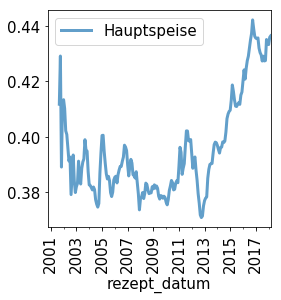

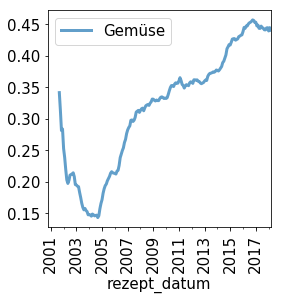

In [10]:
# with top 10 tags and "Schwein"
matplotlib.rcParams.update({'font.size': 15})
for t in tags[:2]:
    f, ax = plt.subplots(figsize=(4,4))
    dX12[t].plot(ax=ax,kind='line',stacked=False,rot=90,lw=3,alpha=0.7)
    plt.legend()

## some distributions

Text(0.5,1,'Mean rating for recipes with >10 ratings')

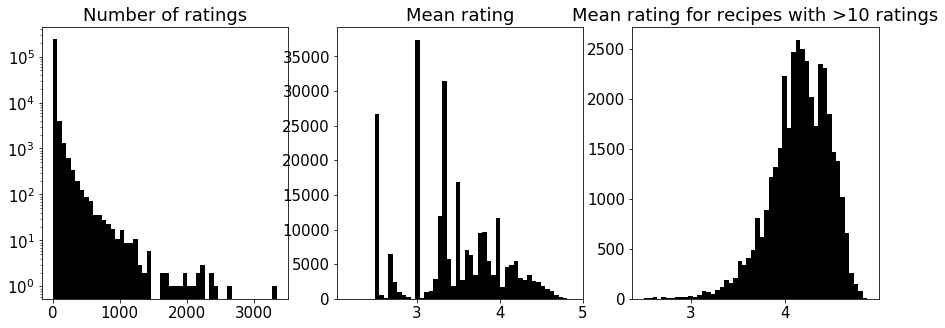

In [11]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
_ = ax1.hist(df['num_votes'].values,bins=50,log=True,color='k')
ax1.set_title('Number of ratings')
_ = ax2.hist(df['avg_vote'].values,bins=50,color='k')
ax2.set_title('Mean rating')
_ = ax3.hist(df[df['num_votes']>10]['avg_vote'],bins=50,color='k')
ax3.set_title('Mean rating for recipes with >10 ratings')